# Plant image classification
This is a semestral project for [Machine Learning and Data Mining class - PV056 ](https://is.muni.cz/auth/predmet/fi/jaro2025/PV056) at FI MUNI. Our goal was to train a model to discriminate plant diseases given their images using the [PlaintVillage dataset](https://github.com/spMohanty/PlantVillage-Dataset)

Authors:
* Lucia Jančeková
* Dominik Trúchly
* Martin Hlinský
* Šárka Blaško

We tried two different implementation approaches for plant image classification. Then we experimented with explanations using GroundingDINO and segmentation using Segment Anything.

Content:
1. Plant image classification - PyTorch
2. Plant image classification - Tensorflow
3. Visual explanation - GroundingDINO and Segment Anything

## 1. Plant image classification in PyTorch

Authors:
* Lucia Jančeková
* Dominik Trúchly

In [1]:
#importing the required modules
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as model
from PIL import Image

In [2]:

from torchvision import datasets
from torch.utils.data import random_split

#setup device agnostic code(using the GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
!wget https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip .

--2025-04-15 08:05:27--  https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/refs/heads/master [following]
--2025-04-15 08:05:27--  https://codeload.github.com/spMohanty/PlantVillage-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [                <=> ]   2.33G  30.2MB/s    in 75s     

2025-04-15 08:06:43 (32.0 MB/s) - ‘master.zip’ saved [2503722083]

--2025-04-15 08:06:43--  http://./
Resolving . (.)... failed: No address associated with hostname.
w

In [4]:
!unzip master.zip -d .

Výstupní stream byl oříznut na posledních 5000 řádků.
  inflating: ./PlantVillage-Dataset-master/raw/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6f407e70-a20b-4efa-a156-13dd33eaf0ec___UF.GRC_YLCV_Lab 08427_final_masked.jpg  
  inflating: ./PlantVillage-Dataset-master/raw/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6f40ff2f-54a5-47b1-afbd-89556ea5a08d___UF.GRC_YLCV_Lab 02832_final_masked.jpg  
  inflating: ./PlantVillage-Dataset-master/raw/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6f4895d3-c997-4b05-9678-59c53951602f___UF.GRC_YLCV_Lab 02999_final_masked.jpg  
  inflating: ./PlantVillage-Dataset-master/raw/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6f554285-e52f-440a-8ea5-e1295b2a9ff3___UF.GRC_YLCV_Lab 02028_final_masked.jpg  
  inflating: ./PlantVillage-Dataset-master/raw/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6f7eb4df-9d20-42b5-8fbd-09459d858544___UF.GRC_YLCV_Lab 03014_final_masked.jpg  
  inflating: ./PlantVillage-Dataset-master/raw/segmented/Tomato___

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import time
import copy

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Define the data directory
data_dir = "/content/PlantVillage-Dataset-master/raw/color"

# 1. Reduce image size
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reduced from 256x256
    transforms.RandomResizedCrop(192, scale=(0.8, 1.0)),  # Reduced from 224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)


In [7]:
# Split dataset into train (70%), validation (10%), and test (20%) sets
total_size = len(train_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    train_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Update test_dataset transform
test_dataset.dataset.transform = test_transform


In [8]:
# Create DataLoaders with more workers
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Get number of classes
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 38


In [9]:
# Hybrid approach: Train only later layers
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

# Freeze first 70% of layers for even faster training
for i, layer in enumerate(model.features):
    if i < len(model.features) * 0.7:
        for param in layer.parameters():
            param.requires_grad = False

# New classifier
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[0].in_features, 512),
    nn.Hardswish(),
    nn.Dropout(p=0.2),
    nn.Linear(512, num_classes)
)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 81.1MB/s]


In [10]:
# 4. Use a simpler optimizer setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.1,
    patience=3,
)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15, patience=2):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            predictions = model(images)
            # Calculate the loss
            loss = criterion(predictions, labels)
            loss.backward()
            # Update the weights
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(predictions, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                predictions = model(images)
                _, predicted = torch.max(predictions, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        # Update learning rate
        scheduler.step(val_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Acc: {val_acc:.4f}")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    print("Training complete.")
    model.load_state_dict(best_model_wts)
    return model


num_epochs = 15
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/15
Train Loss: 0.3288, Train Acc: 0.9016
Val Acc: 0.9490
Epoch 2/15
Train Loss: 0.0851, Train Acc: 0.9707
Val Acc: 0.9727
Epoch 3/15
Train Loss: 0.0548, Train Acc: 0.9815
Val Acc: 0.9744
Epoch 4/15
Train Loss: 0.0450, Train Acc: 0.9850
Val Acc: 0.9757
Epoch 5/15
Train Loss: 0.0360, Train Acc: 0.9880
Val Acc: 0.9746
Epoch 6/15
Train Loss: 0.0316, Train Acc: 0.9896
Val Acc: 0.9818
Epoch 7/15
Train Loss: 0.0245, Train Acc: 0.9916
Val Acc: 0.9843
Epoch 8/15
Train Loss: 0.0286, Train Acc: 0.9917
Val Acc: 0.9764
Epoch 9/15
Train Loss: 0.0209, Train Acc: 0.9931
Val Acc: 0.9762
Early stopping triggered
Training complete.


In [11]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the trained model
evaluate_model(model, test_loader)

Test Accuracy: 0.9832


In [12]:
# Save the model
torch.save(model.state_dict(), "plant_disease_mobilenet.pth")
print("Model saved successfully!")
pytorchmodel = model

Model saved successfully!


## 2. Plant image classification in Tensorflow
Authors:
* Martin Hlinský
* Šárka Blaško


### Dataset overview
We used PlantVillage Dataset (https://github.com/spMohanty/PlantVillage-Dataset/). This code downloads and unzipps the images to google colab for further processing.

In [13]:
# delete variables - clean previous if any
import gc
gc.collect()

import os

dataset_dir = "/content/PlantVillage-Dataset-master/raw/color"

if not os.path.exists(dataset_dir):
    print("Zip not found, downloading...")
    !wget -q https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip
else:
    print("Zip already exists, skipping download.")

Zip already exists, skipping download.


In [14]:
if not os.path.exists(dataset_dir):
    print("Dataset not found, unzipping...")
    !unzip -q master.zip -d .
else:
    print("Dataset already exists, skipping unzipping.")

Dataset already exists, skipping unzipping.


Now, let's take a look at the dataset. We list the classes that we have and take a look at some images.

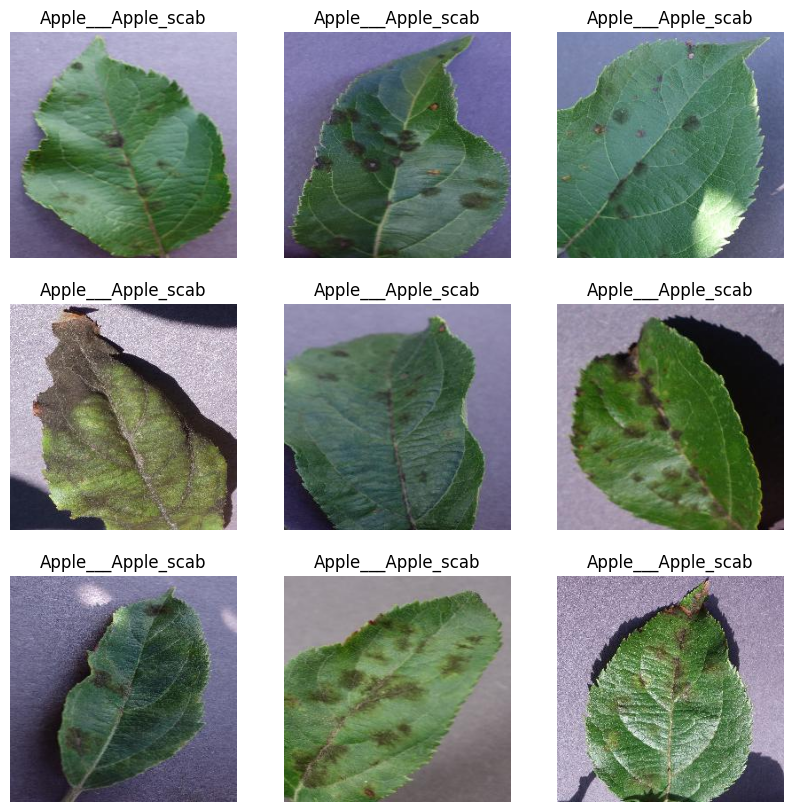

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import datetime
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Path to dataset
dataset_path = "/content/PlantVillage-Dataset-master/raw/color"

# Find first class folder
first_class = sorted(os.listdir(dataset_path))[0]
image_folder = os.path.join(dataset_path, first_class)

# Get first 9 image paths (sorted for consistency)
image_files = sorted([os.path.join(image_folder, f)
                      for f in os.listdir(image_folder)
                      if f.lower().endswith('.jpg')])[:9]

# Plot images
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_files):
    img = Image.open(image_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(first_class)
    plt.axis("off")

plt.show()


### Train a model

In [16]:
start_time = datetime.datetime.now()

# Data Augmentation
data_augmentation = Sequential([
    RandomRotation(0.25),
    RandomZoom(0.1),
])

# Early stopping
early_stopping = EarlyStopping(
    patience=3,              # If results don't get better after 3 epochs
    restore_best_weights=True # We want to retrieve best results
)

# Dataset Path and Loading
dataset_path = "/content/PlantVillage-Dataset-master/raw/color"
batch_size = 32
img_height = 224
img_width = 224
seed = 123
AUTOTUNE = tf.data.AUTOTUNE

# tensorflow supports 2 way split, so if we want train, test and validation dataset, we have to do it differently:
# Step 1: Split 90% train_val, 10% test
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


# Get class names
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print("Number of classes: ", num_classes, "\n")

# Step 2: Manually split train_val_ds into train and val (e.g. 7:2 ratio of 90%)
train_val_batches = tf.data.experimental.cardinality(train_val_ds).numpy()
train_size = int(train_val_batches * 0.777)  # ~70% of original
val_size = train_val_batches - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)


# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# --- Model Definition ---
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

input_tensor = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(input_tensor)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# --- Training ---
print("Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=2,
    callbacks=[early_stopping],
)

print("\n","Training finished.")
total_time = datetime.datetime.now() - start_time
print("Total training time: ", total_time)

Found 54305 files belonging to 38 classes.
Using 48875 files for training.
Found 54305 files belonging to 38 classes.
Using 5430 files for validation.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,387,273 (16.74 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Training...
Epoch 1/20
1187/1187 - 155s - 131ms/step - accuracy: 0.8209 - loss: 0.6101 - val_accuracy: 0.9171 - val_loss: 0.2473
Epoch 2/20
1187/1187 - 163s - 137ms/step - accuracy: 0.9028 - loss: 0.2972 - val_accuracy: 0.9404 - val_loss: 0.1737
Epoch 3/20
1187/1187 - 133s - 112ms/step - accuracy: 0.9142 - loss: 0.2540 - val_accuracy: 0.9570 - val_loss: 0.1316
Epoch 4/20
1187/1187 - 133s - 112ms/step - accuracy: 0.9223 - loss: 0.2299 - val_accuracy: 0.9584 - val_loss: 0.1267
Epoch 5/20
1187/1187 - 162s - 137ms/step - accuracy: 0.9267 - loss: 0.2204 - val_accuracy: 0.9537 - val_loss: 0.1363
Epoch 6/20
1187/1187 - 133s - 112ms/step - accuracy: 0.9286 - loss: 0.2102 - val_accuracy: 0.9536 - val_loss: 0.1308
Epoch 7/20
1187/1187 - 132s - 112ms/step - accuracy: 0.9317 - loss: 0.2012 - val_accuracy: 0.9561 - val_loss: 0.1304

 Training finished.
Total training time:  0:16:58.195282


### Evaluate

In [17]:
print("Evaluating on test dataset...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)
tensorflowmodel = model
print(f"\nTest accuracy: {test_accuracy:.4f}")

Evaluating on test dataset...
170/170 - 12s - 71ms/step - accuracy: 0.9621 - loss: 0.1193

Test accuracy: 0.9621


### Visualize the results

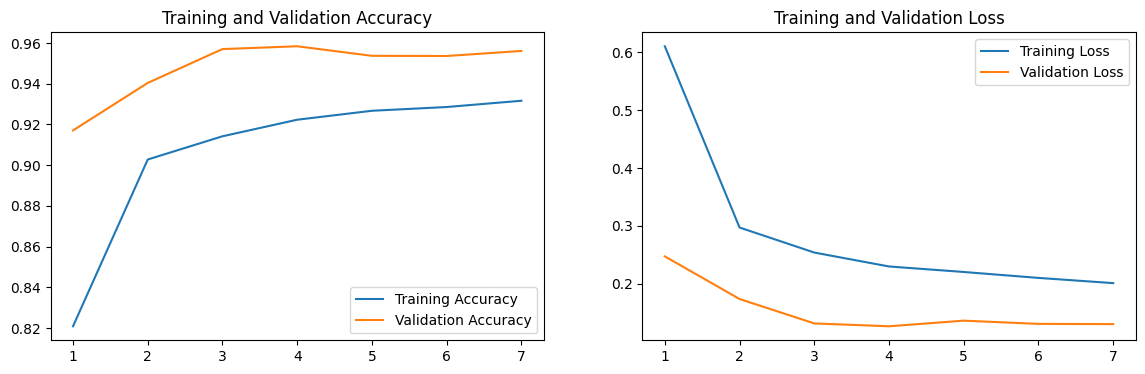

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Confusion matrix
Where did the model most mistakes?

In [19]:
# --- Confusion Matrix ---
from sklearn.metrics import confusion_matrix
print("\nComputing confusion matrix...\n")
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)  # suppress individual batch logs
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

# Identify most confused classes
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 0:
            confused_pairs.append(((class_names[i], class_names[j]), cm[i][j]))

confused_pairs.sort(key=lambda x: x[1], reverse=True)
print("Top 5 most confused class pairs:")
for (actual, predicted), count in confused_pairs[:5]:
    print(f"{actual} → {predicted}: {count} times")


Computing confusion matrix...

Top 5 most confused class pairs:
Tomato___Bacterial_spot → Tomato___Septoria_leaf_spot: 13 times
Corn_(maize)___Northern_Leaf_Blight → Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 11 times
Tomato___Early_blight → Tomato___Bacterial_spot: 11 times
Tomato___Early_blight → Tomato___Septoria_leaf_spot: 10 times
Tomato___Early_blight → Tomato___Late_blight: 9 times


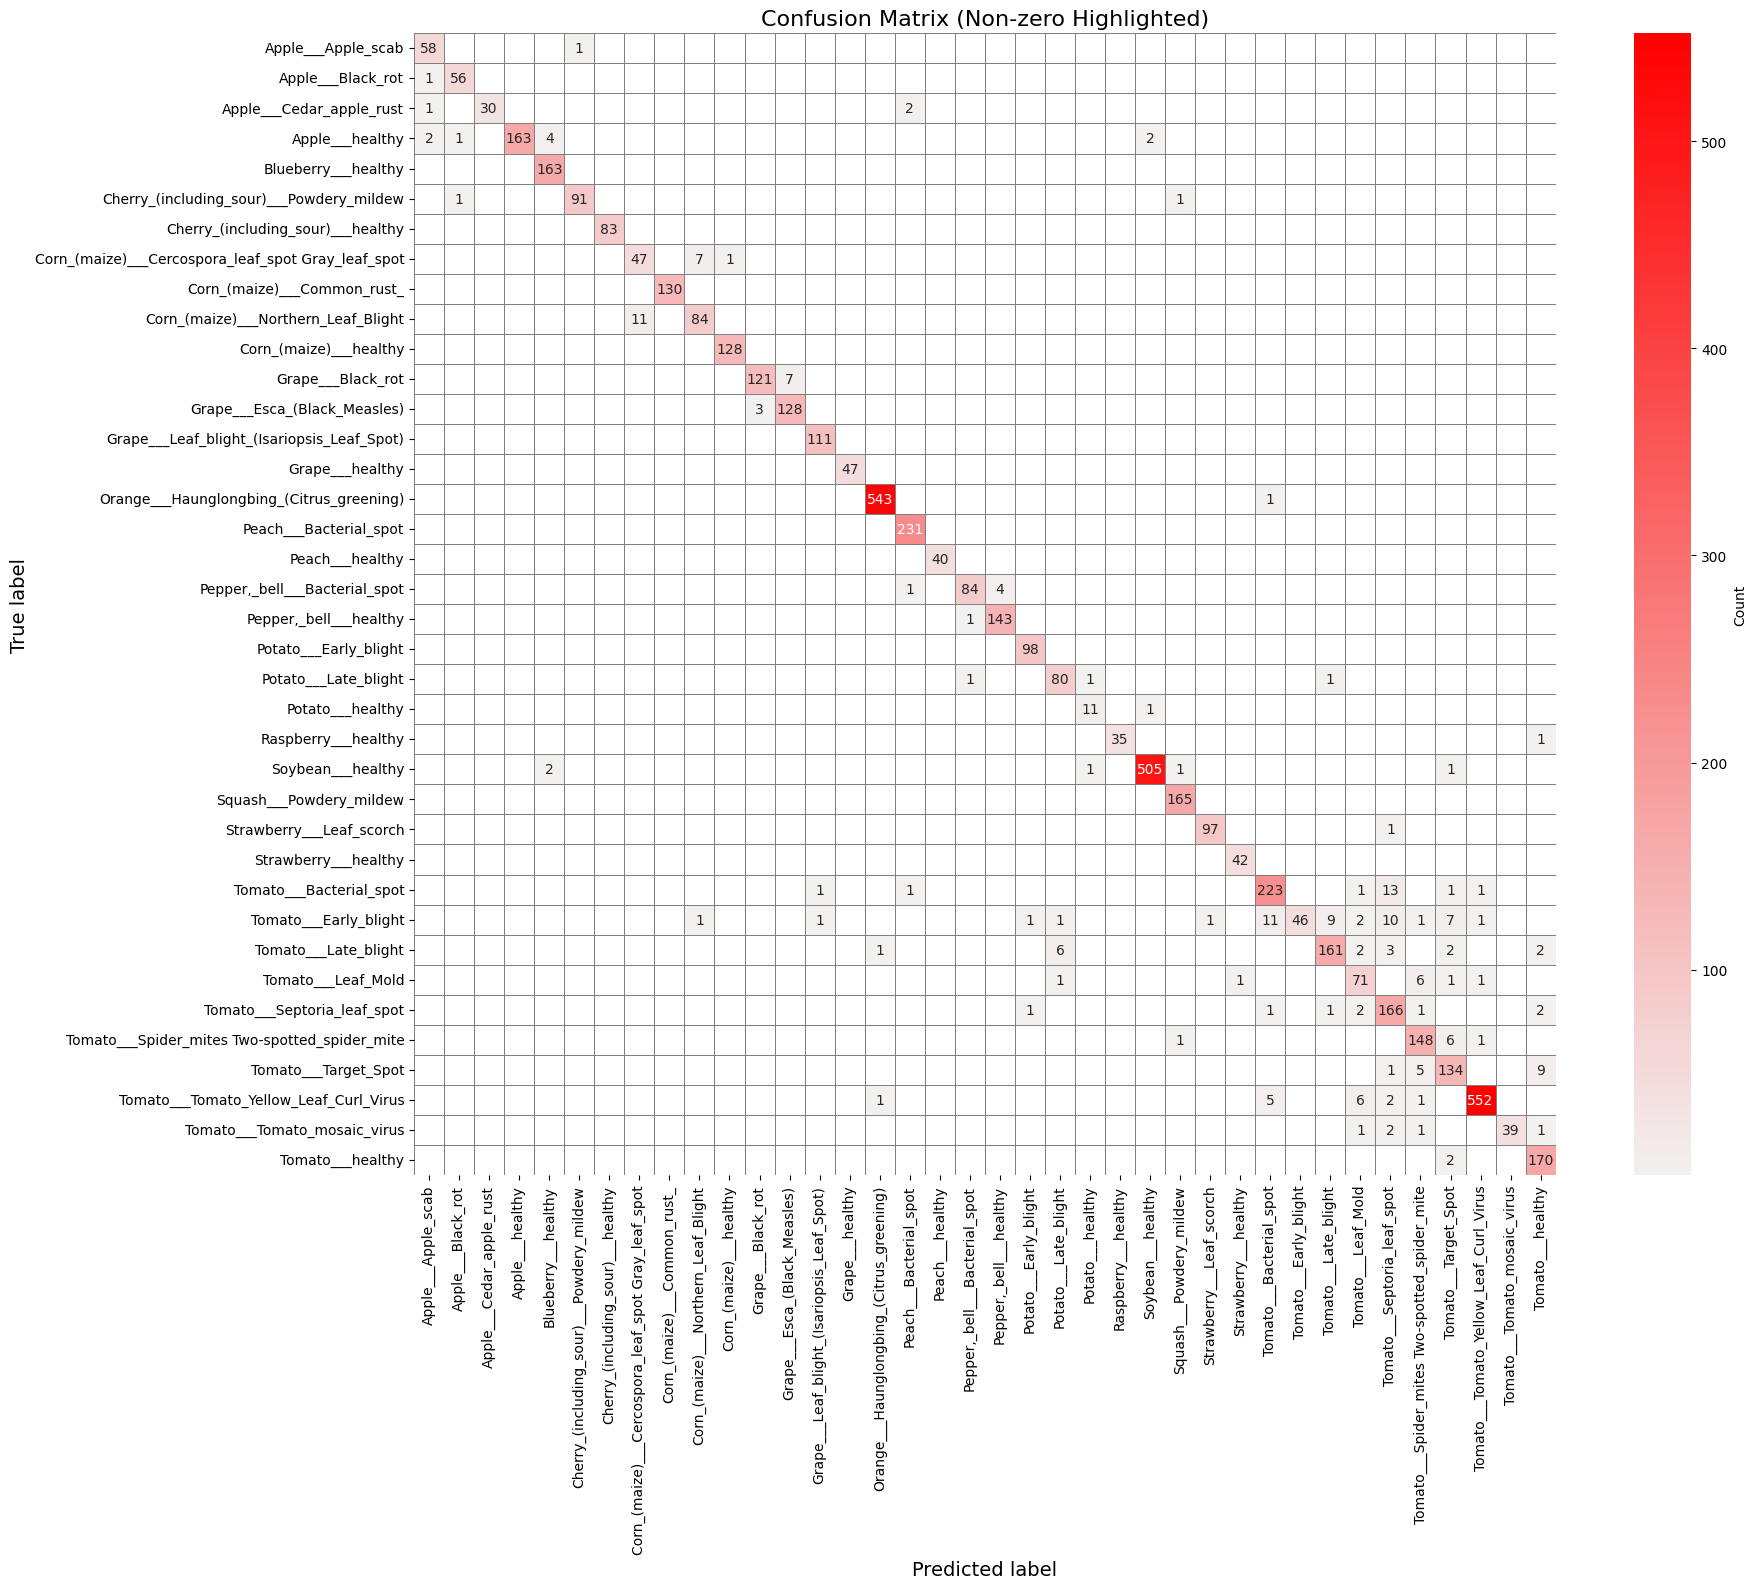

In [20]:
# --- Confusion Matrix Plot ---
!pip install seaborn  # If seaborn is not installed yet
import seaborn as sns
# Create a custom mask to highlight non-zero cells
plt.figure(figsize=(20, 16))
mask = (cm == 0)
sns.heatmap(
    cm,
    mask=mask,  # hide zero cells
    annot=True,
    fmt="d",
    cmap=sns.light_palette("red", as_cmap=True),
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Count'}
)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Confusion Matrix (Non-zero Highlighted)", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.tight_layout()
plt.show()

##3. Visual explanation using GroundingDINO and segmentation using Segment Anything


In the following two parts, we use one of our trained models to classify the plant disease.
We also use pretrained models to:

* Create bounding boxes for specific spots in the image using GroundingDINO.
* Segment the areas marked by these bounding boxes using Segment Anything.

The goal is to see exactly where in the picture the disease is visible.

### Installation

First we have to setup a directory hierarchy and install needed components though. We do it all in this step to not repeat it when we check for diseases in other images.

In [21]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [22]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 10.19 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [23]:
# Thank you random Github user🫡
# https://github.com/IDEA-Research/Grounded-Segment-Anything/issues/550
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [24]:
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install supervision
!pip install GroundingDINO

/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB

In [25]:
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [26]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [27]:
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [28]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

dinomodel = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
%cd {HOME}

/content


In [30]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.9 MB/s eta 0:00:00


In [31]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [32]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


### Setting up for detection and segmentation

In this part, we:

1. Define variables for the images we want to use.  
2. Select one specific image to examine in detail.  
3. Use our trained model to predict which plant disease is present in the selected image.


In [33]:
image_1 = "/content/PlantVillage-Dataset-master/raw/color/Apple___Apple_scab/5dbcba87-93fa-4c21-8abd-bc20c93b359f___FREC_Scab 3258.JPG"
image_2 = "/content/PlantVillage-Dataset-master/raw/color/Apple___Black_rot/032cf235-07ff-478f-b347-d55c07835bc5___JR_FrgE.S 8778.JPG"
image_3 = "/content/PlantVillage-Dataset-master/raw/color/Apple___Cedar_apple_rust/072f23fb-0b1a-43b9-a548-3981120ff33c___FREC_C.Rust 0133.JPG"
image_4 = "/content/PlantVillage-Dataset-master/raw/color/Cherry_(including_sour)___Powdery_mildew/012b55cf-de7a-483a-9118-0fd8ff012185___FREC_Pwd.M 0423.JPG"
image_5 = "/content/PlantVillage-Dataset-master/raw/color/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/038464d1-47a9-4169-afb1-72c87e568a95___RS_GLSp 4480.JPG"
image_6 = "/content/PlantVillage-Dataset-master/raw/color/Corn_(maize)___Common_rust_/RS_Rust 1567.JPG"
image_7 = "/content/PlantVillage-Dataset-master/raw/color/Corn_(maize)___Northern_Leaf_Blight/0118e276-ee7b-4fed-961d-057590ae9f7f___RS_NLB 4666 copy 2.jpg"
image_8 = "/content/PlantVillage-Dataset-master/raw/color/Grape___Black_rot/006efc68-9e46-4168-921c-10ef8065702c___FAM_B.Rot 3470.JPG"
image_9 = "/content/PlantVillage-Dataset-master/raw/color/Grape___Esca_(Black_Measles)/02223cc6-30d2-408d-a091-65257d044a50___FAM_B.Msls 0908.JPG"
image_10 = "/content/PlantVillage-Dataset-master/raw/color/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/01cdbd4c-bd3e-4277-8e84-60700397daaf___FAM_L.Blight 4755.JPG"
image_11 = "/content/PlantVillage-Dataset-master/raw/color/Peach___Bacterial_spot/00f87dfc-bf6c-481e-9022-bfb98224d4b7___Rutg._Bact.S 1965.JPG"
image_12 = "/content/PlantVillage-Dataset-master/raw/color/Pepper,_bell___Bacterial_spot/032aa7c4-0a95-4f09-b0bb-1242f4f32d82___NREC_B.Spot 1889.JPG"
image_13 = "/content/PlantVillage-Dataset-master/raw/color/Potato___Early_blight/05c35093-11b8-4cd0-b67a-148859754440___RS_Early.B 8939.JPG"
image_14 = "/content/PlantVillage-Dataset-master/raw/color/Potato___Late_blight/0201bf8e-27e3-4c92-ae97-2fb4f665b5d3___RS_LB 4320.JPG"
image_15 = "/content/PlantVillage-Dataset-master/raw/color/Squash___Powdery_mildew/01f4ace1-e82c-4ac6-b0fe-b0d5b114b57e___UMD_Powd.M 0731.JPG"
image_16 = "/content/PlantVillage-Dataset-master/raw/color/Strawberry___Leaf_scorch/0361a9eb-143c-4ce2-b933-ee4a84524b27___RS_L.Scorch 1258.JPG"
image_17 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Bacterial_spot/030501db-683b-4ed5-9ec0-c475a5dfdd76___GCREC_Bact.Sp 5650.JPG"
image_18 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Early_blight/07324d80-17c5-4541-9702-62e9c744ac07___RS_Erly.B 7455.JPG"
image_19 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Late_blight/01ebf21e-ef94-4c92-b007-0b26741c2fc8___GHLB2 Leaf 9075.JPG"
image_20 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Leaf_Mold/05bbff69-adad-4e16-8fad-c265be82e25a___Crnl_L.Mold 6929.JPG"
image_21 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Septoria_leaf_spot/041684a2-1a2c-430f-ab09-b17293f015bc___JR_Sept.L.S 8400.JPG"
image_22 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Spider_mites Two-spotted_spider_mite/012369f5-ca64-4811-888f-35d75f7f7c2b___Com.G_SpM_FL 8911.JPG"
image_23 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Target_Spot/01e0b8b1-e713-4c6d-973b-f7636280c58a___Com.G_TgS_FL 9816.JPG"
image_24 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0112d4b1-6cf3-4a5b-a87c-792eef80637a___YLCV_NREC 2744.JPG"
image_25 = "/content/PlantVillage-Dataset-master/raw/color/Tomato___Tomato_mosaic_virus/0bf3eb4c-e2cd-4e72-8834-4fc045bd67ae___PSU_CG 2414.JPG"

SELECTED_IMAGE = image_1

In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(SELECTED_IMAGE, target_size=(224, 224))

In [35]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # add batch dimension
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

In [36]:
preds = tensorflowmodel.predict(img_array)
predicted_index = np.argmax(preds, axis=1)[0]
predicted_label = class_names[predicted_index]

print("Predicted class:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
Predicted class: Apple___Apple_scab


Here we define approximate attributes of each plant disease manually. This is used for GroundingDINO model later. If there are typically more signs than one, we use " . ".

In [37]:
label_to_prompt = {
    "Apple___Apple_scab": "brown spot on green",
    "Apple___Black_rot": "brown spot on green",
    "Apple___Cedar_apple_rust": "brown spot on green . white spot on green",
    "Cherry_(including_sour)___Powdery_mildew": "brown spot on green . white line on green",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": "brown spot on green",
    "Corn_(maize)___Common_rust_": "brown spot on green",

    "Corn_(maize)___Northern_Leaf_Blight": "brown spot on green . white line on green",
    "Grape___Black_rot": "brown spot on green",
    "Grape___Esca_(Black_Measles)": "brown spot on green",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)": "brown spot on green",
    "Peach___Bacterial_spot": "brown spot on green . brown spot on yellow",

    "Pepper,_bell___Bacterial_spot": "brown spot on green . brown spot on yellow",
    "Potato___Early_blight": "brown spot on green",
    "Potato___Late_blight": "brown spot on green",
    "Squash___Powdery_mildew": "brown spot on green . white line on green",
    "Strawberry___Leaf_scorch": "brown spot on green . red spot on green",

    "Tomato___Bacterial_spot": "brown spot on green . brown spot on yellow",
    "Tomato___Early_blight": "brown spot on green . brown spot on yellow",
    "Tomato___Late_blight": "brown spot on green . brown spot on yellow",
    "Tomato___Leaf_Mold": "yellow spot on green",
    "Tomato___Septoria_leaf_spot": "brown spot on green . brown spot on yellow",

    "Tomato___Spider_mites Two-spotted_spider_mite": "white spot on green",
    "Tomato___Target_Spot": "white spot on green",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "yellow spot on green",
    "Tomato___Tomato_mosaic_virus": "white line on green . yellow spot on green",

    # Healthy plants do not need segmentation of bad parts
    "Tomato___healthy": "",
    "Potato___healthy": "",
    "Corn_(maize)___healthy": "",
    "Peach___healthy": "",
    "Pepper,_bell___healthy": "",

    "Grape___healthy": "",
    "Strawberry___healthy": "",
    "Cherry_(including_sour)___healthy": "",
    "Apple___healthy": "",
    "Orange___Haunglongbing_(Citrus_greening)": "",

    "Raspberry___healthy": "",
    "Soybean___healthy": ""
}

prompt = label_to_prompt.get(predicted_label, "disease symptom")
print(prompt)

brown spot on green


### GroundingDINO

In this part we focus on searching where the disease is located on the plant. We used implementation [from this demo](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb#scrollTo=rH62Frfih5lY).

In [38]:
!nvidia-smi

Tue Apr 15 08:48:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             44W /   70W |    1444MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

This is exactly as done in the demo. We have one important part though and that is `remove_combined=True` parameter, which is necessary because otherwise it tried to search also single tokens instead of using prompt as a whole context.

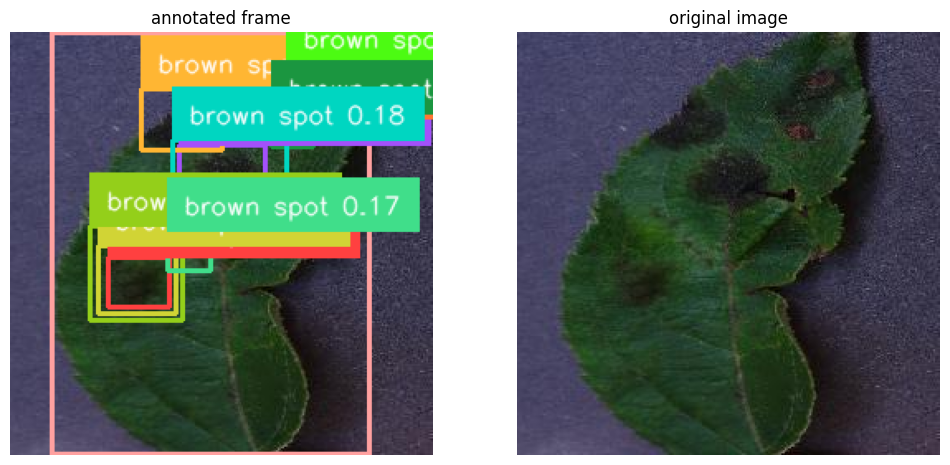

In [39]:
import os
import supervision as sv
import cv2

BOX_TRESHOLD = 0.15
TEXT_TRESHOLD = 0.15

image_source, image = load_image(SELECTED_IMAGE)

boxes, logits, phrases = predict(
    model=dinomodel,
    image=image,
    caption=prompt,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    remove_combined=True
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline

image_bgr = cv2.imread(SELECTED_IMAGE)

sv.plot_images_grid(
    images=[annotated_frame, image_bgr],
    grid_size=(1, 2),
    titles=['annotated frame', 'original image']
)

In [40]:
print(boxes)

tensor([[0.5020, 0.3444, 0.2060, 0.1559],
        [0.3056, 0.5926, 0.1440, 0.1188],
        [0.4735, 0.4999, 0.7485, 1.0000],
        [0.6678, 0.2330, 0.0744, 0.0537],
        [0.4055, 0.2075, 0.1919, 0.1471],
        [0.3011, 0.5860, 0.1815, 0.1579],
        [0.7151, 0.1206, 0.1237, 0.0893],
        [0.2992, 0.5703, 0.2187, 0.2212],
        [0.4223, 0.5176, 0.1017, 0.0970],
        [0.6686, 0.2328, 0.0975, 0.0799],
        [0.5202, 0.3493, 0.2720, 0.1884]])


We transform bounding boxes with centers and sizes to bounding boxes which denote exactly where each one starts and ends. We also clean up data that is not useful, since GroundingDINO tends to mark the whole leaf often for some reason.

In [41]:
new_boxes = []
HEIGHT, WIDTH = image_source.shape[:2]
for x_c, y_c, w, h in boxes:
  if w < 0.7 and h < 0.7: #and w > 0.1 and h > 0.1:
    x_1 = (x_c - w / 2) * WIDTH
    y_1 = (y_c - h / 2) * HEIGHT
    x_2 = (x_c + w / 2) * WIDTH
    y_2 = (y_c + h / 2) * HEIGHT
    new_boxes.append([int(x_1), int(y_1), int(x_2), int(y_2)])

In [42]:
import numpy as np
box = np.array(new_boxes[0])
print(box)

[102  68 154 108]


### Segment Anything

After we have found our bounding boxes, we use them to find our segmentations. This is done by Segment Anything and uses [this demo](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=G3CtzYroC2Lb), although it doesn't lean on it as heavily as the previous part.

In [43]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [44]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [45]:
import numpy as np
import supervision as sv

image_bgr = cv2.imread(SELECTED_IMAGE)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

The biggest change is that we often have to draw more segmented boxes than one in our case. This function does exactly that. We then go through each bounding box, call the function and try to segment the disease.

In [46]:
def draw_segmented_box(box, selected_image):
  masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
  )
  box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
  mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

  detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
  )
  detections = detections[detections.area == np.max(detections.area)]
  source_image = box_annotator.annotate(scene=selected_image.copy(), detections=detections)
  segmented_image = mask_annotator.annotate(scene=selected_image.copy(), detections=detections)
  return source_image, segmented_image

In [47]:
source_images = []
segmented_images = []

for new_box in new_boxes:
  selected_image = image_bgr
  if segmented_images:
    selected_image = segmented_images[-1]
  box = np.array(new_box)
  source_image, segmented_image = draw_segmented_box(box, selected_image)
  source_images.append(source_image)
  segmented_images.append(segmented_image)

We then display the original image and segmented image next to each other.

In some cases it works pretty well and segments basically every single thing, but sometimes it doesn't work so well. Other than that, it seems to do its job more often than not.

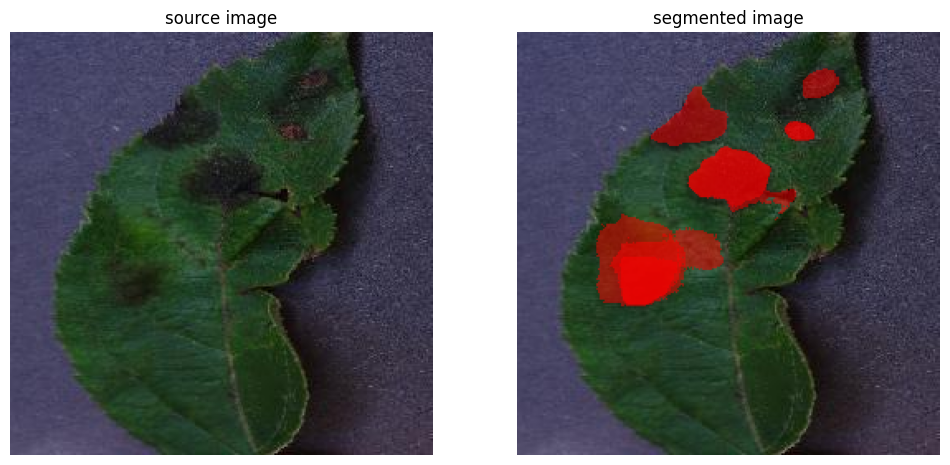

In [48]:
sv.plot_images_grid(
    images=[image_bgr, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)